BASELINE MODELS TABLE

In [22]:
import pandas as pd
from pathlib import Path

metrics = pd.read_csv("../reports/metrics_pair_noq/metrics_summary.tsv", sep="\t")

# Keep only columns you care to show
cols = [
    "model",
    "test_accuracy",
    "test_precision",
    "test_recall",
    "test_f1",
    "test_roc_auc",
]
tab_baseline = metrics[cols].copy()

# Optional: round for prettier LaTeX
tab_baseline = tab_baseline.round(3)

Path("tables").mkdir(exist_ok=True)
tab_baseline.to_latex(
    "tables/baseline_models_pair_noq.tex",
    index=False,
    caption="Performance of baseline classifiers on the held-out test set.",
    label="tab:baseline_models_pair_noq",
    escape=False
)

Tuned models table

In [23]:
tuned = pd.read_csv("../reports/hparam_tuning_pair_noq/tuned_models_summary.tsv", sep="\t")

cols_tuned = [
    "model",
    "test_accuracy",
    "test_precision",
    "test_recall",
    "test_f1",
    "test_roc_auc",
]
tab_tuned = tuned[cols_tuned].copy().round(3)

Path("tables").mkdir(exist_ok=True)
tab_tuned.to_latex(
    "tables/tuned_models_pair_noq.tex",
    index=False,
    caption="Performance of tuned classifiers on the held-out test set.",
    label="tab:tuned_models_pair_noq",
    escape=False
)

Baseline F1 bar chart


In [24]:
from pathlib import Path

Path("figures").mkdir(parents=True, exist_ok=True)

In [25]:
import matplotlib.pyplot as plt

metrics_sorted = metrics.sort_values("test_f1", ascending=False)

plt.figure(figsize=(7, 4))
plt.barh(metrics_sorted["model"], metrics_sorted["test_f1"])
plt.xlabel("Test F1")
plt.title("Baseline models")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("figures/baseline_f1_pair.png", dpi=300, bbox_inches="tight")
plt.close()

Before vs after tuning (F1 + AUC)

In [26]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

Path("figures").mkdir(parents=True, exist_ok=True)

In [30]:
from pathlib import Path

baseline_path = Path("../reports/metrics_pair_noq/metrics_summary.tsv")
tuned_path    = Path("../reports/hparam_tuning_pair_noq/tuned_models_summary.tsv")

baseline = pd.read_csv(baseline_path, sep="\t")
tuned    = pd.read_csv(tuned_path,    sep="\t")

# Clean up old column if present
for df in (baseline, tuned):
    if "model_base" in df.columns:
        del df["model_base"]

# Normalised key
tuned["model_base"]    = tuned["model"].str.replace("_tuned$", "", regex=True)
baseline["model_base"] = baseline["model"]

# Drop original 'model' to avoid suffix clash
for df in (baseline, tuned):
    if "model" in df.columns:
        del df["model"]

# Merge
merged = baseline.merge(
    tuned,
    on="model_base",
    suffixes=("_base", "_tuned"),
)

# Nice display name and sort by tuned F1
merged["model_name"] = merged["model_base"]
merged = merged.sort_values("test_f1_tuned", ascending=False).reset_index(drop=True)

# This is what the plotting code expects
plot_df = merged.copy()

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

axes[0].bar(plot_df["model_name"], plot_df["test_f1_base"], label="baseline")
axes[0].bar(plot_df["model_name"], plot_df["test_f1_tuned"], alpha=0.7, label="tuned")
axes[0].set_xticklabels(plot_df["model_name"], rotation=45, ha="right")
axes[0].set_ylabel("Test F1")
axes[0].set_title("F1 before vs after tuning")
axes[0].legend()

axes[1].bar(plot_df["model_name"], plot_df["test_roc_auc_base"], label="baseline")
axes[1].bar(plot_df["model_name"], plot_df["test_roc_auc_tuned"], alpha=0.7, label="tuned")
axes[1].set_xticklabels(plot_df["model_name"], rotation=45, ha="right")
axes[1].set_ylabel("Test ROC–AUC")
axes[1].set_title("ROC–AUC before vs after tuning")
axes[1].legend()

plt.tight_layout()
plt.savefig("figures/f1_auc_tuning_pair.png", dpi=300, bbox_inches="tight")
plt.close()

/var/folders/sj/r5b1vnb91cjffx5_zt6rs8v80000gn/T/ipykernel_90941/3162811958.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(plot_df["model_name"], rotation=45, ha="right")
/var/folders/sj/r5b1vnb91cjffx5_zt6rs8v80000gn/T/ipykernel_90941/3162811958.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(plot_df["model_name"], rotation=45, ha="right")


ROC + PR curves

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from joblib import load

from mitochime.hyperparam_search_top import load_dataset
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
)

In [33]:
# 1) Load test set (no-quality)
X_test, y_test, feature_names = load_dataset("../data/processed/PAIR_test_noq.tsv")

# 2) Load tuned models you want to analyse
models = {
    "catboost":           load("../models_pair_noq_tuned/catboost_tuned.joblib"),
    "gradient_boosting":  load("../models_pair_noq_tuned/gradient_boosting_tuned.joblib"),
    "bagging_trees":      load("../models_pair_noq_tuned/bagging_trees_tuned.joblib"),
    "mlp":                  load("../models_pair_noq_tuned/mlp_tuned.joblib"),
}

In [34]:
import json
import pandas as pd
from pathlib import Path

# Pick the dataset that matches your trained models (PAIR_noq)
tsv_path = "../data/processed/PAIR_train_noq.tsv"  # or PAIR_test_noq.tsv

df = pd.read_csv(tsv_path, sep="\t")

# IMPORTANT: do NOT convert strand to numeric here
num_cols = df.select_dtypes(include="number").columns.tolist()
feature_cols = [c for c in num_cols if c != "label"]  # should be 23

print("Saved n_features:", len(feature_cols))
print("Features:", feature_cols)

out = Path("../models_PAIR_noq_tuned/PAIR_feature_cols.json")  # put near your tuned models
out.parent.mkdir(parents=True, exist_ok=True)
json.dump(feature_cols, open(out, "w"), indent=2)
print("Wrote:", out)

Saved n_features: 23
Features: ['read_length', 'mapq', 'has_sa', 'sa_count', 'num_segments', 'sa_diff_contig', 'sa_min_delta_pos', 'sa_max_delta_pos', 'sa_mean_delta_pos', 'sa_same_strand_count', 'sa_opp_strand_count', 'sa_max_mapq', 'sa_mean_mapq', 'sa_min_nm', 'sa_mean_nm', 'softclip_left', 'softclip_right', 'total_clipped_bases', 'breakpoint_read_pos', 'kmer_cosine_diff', 'kmer_js_divergence', 'microhomology_length', 'microhomology_gc']
Wrote: ../models_PAIR_noq_tuned/PAIR_feature_cols.json


In [35]:
import json
import pandas as pd
import numpy as np

FEATURES_PATH = "../models_PAIR_noq_tuned/PAIR_feature_cols.json"
feature_cols = json.load(open(FEATURES_PATH))
print("Canonical n_features:", len(feature_cols))

df = pd.read_csv("../data/processed/PAIR_test_noq.tsv", sep="\t")

# DO NOT map strand here. Just enforce schema:
missing = [c for c in feature_cols if c not in df.columns]
extra = [c for c in df.columns if c not in feature_cols + ["label", "read_id", "ref_name", "cigar", "strand"]]

print("Missing:", missing)
print("Some extra non-feature cols (ok):", extra[:10])

X_test = df[feature_cols].to_numpy(dtype=float)
y_test = df["label"].to_numpy(dtype=int)

print("X_test shape:", X_test.shape)

Canonical n_features: 23
Missing: []
Some extra non-feature cols (ok): []
X_test shape: (7997, 23)


X23: (7997, 23) | X24: (7997, 24)
GB expects n_features_in_: 24
Using: X24 (with strand_num)
              precision    recall  f1-score   support

       clean     0.4610    0.0163    0.0314      3997
    chimeric     0.4995    0.9810    0.6619      4000

    accuracy                         0.4988      7997
   macro avg     0.4802    0.4986    0.3467      7997
weighted avg     0.4802    0.4988    0.3468      7997



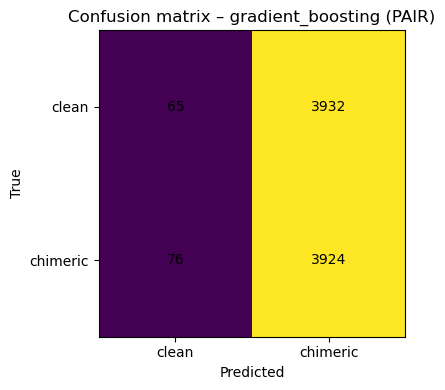

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from joblib import load

PAIR_TEST = "../data/processed/PAIR_test_noq.tsv"
GB_PATH   = "../models_PAIR_noq_tuned/gradient_boosting_tuned.joblib"

def build_X_variants(df: pd.DataFrame):
    df2 = df.copy()

    # create numeric strand column (for 24-feature models)
    if "strand" in df2.columns:
        df2["strand_num"] = df2["strand"].map({"+": 1.0, "-": 0.0}).astype(float)
    else:
        df2["strand_num"] = np.nan

    # numeric cols (includes strand_num)
    num_cols = df2.select_dtypes(include="number").columns.tolist()
    feat_cols_24 = [c for c in num_cols if c != "label"]

    # 23-feature version = drop strand_num
    feat_cols_23 = [c for c in feat_cols_24 if c != "strand_num"]

    X24_df = df2[feat_cols_24].copy()
    X23_df = df2[feat_cols_23].copy()
    y = df2["label"].to_numpy(dtype=int)

    return X23_df, feat_cols_23, X24_df, feat_cols_24, y

def plot_cm(cm, title):
    plt.figure(figsize=(4.5, 4.0))
    plt.imshow(cm)
    plt.title(title)
    plt.xticks([0, 1], ["clean", "chimeric"])
    plt.yticks([0, 1], ["clean", "chimeric"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.show()

# ---- load test + build both variants
df = pd.read_csv(PAIR_TEST, sep="\t")
X23_df, feat23, X24_df, feat24, y_test = build_X_variants(df)

X23_np = X23_df.to_numpy(dtype=float)
X24_np = X24_df.to_numpy(dtype=float)

print("X23:", X23_np.shape, "| X24:", X24_np.shape)

# ---- load gradient boosting model
gb_model = load(GB_PATH)
exp = getattr(gb_model, "n_features_in_", None)
print("GB expects n_features_in_:", exp)

# ---- choose correct input matrix
if exp == X23_np.shape[1]:
    X_in = X23_np
    used = "X23 (no strand_num)"
elif exp == X24_np.shape[1]:
    X_in = X24_np
    used = "X24 (with strand_num)"
else:
    raise ValueError(f"GradientBoosting expects {exp}, but available are 23/24.")

print("Using:", used)

# ---- predict + report + CM
y_pred = gb_model.predict(X_in)
y_pred = np.asarray(y_pred).reshape(-1).astype(int)

print(classification_report(
    y_test, y_pred,
    target_names=["clean", "chimeric"],
    digits=4,
    zero_division=0
))

cm = confusion_matrix(y_test, y_pred)
plot_cm(cm, "Confusion matrix – gradient_boosting (PAIR)")

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
)

PAIR_TEST = "../data/processed/PAIR_test_noq.tsv"
OUT_DIR = Path("../figures")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def build_X23_X24_pair(tsv_path: str):
    df = pd.read_csv(tsv_path, sep="\t")
    if "label" not in df.columns:
        raise ValueError("PAIR TSV must contain 'label' column")

    df2 = df.copy()

    # IMPORTANT: convert strand IN PLACE (column stays named 'strand')
    if "strand" in df2.columns:
        df2["strand"] = df2["strand"].map({"+": 1.0, "-": 0.0}).astype(float)

    num_cols = df2.select_dtypes(include="number").columns.tolist()
    feat24 = [c for c in num_cols if c != "label"]          # includes 'strand' if present
    feat23 = [c for c in feat24 if c != "strand"]           # excludes 'strand'

    X24 = df2[feat24].to_numpy(dtype=float)
    X23 = df2[feat23].to_numpy(dtype=float)
    y = df2["label"].to_numpy(dtype=int)

    return X23, feat23, X24, feat24, y

def get_scores_sklearn(model, X):
    # returns continuous scores for class 1
    if hasattr(model, "predict_proba"):
        return np.asarray(model.predict_proba(X)[:, 1]).reshape(-1)
    if hasattr(model, "decision_function"):
        s = np.asarray(model.decision_function(X))
        if s.ndim > 1:
            s = s[:, 1]
        return s.reshape(-1)
    return None

def pick_X_for_model(model, X23, X24):
    exp = getattr(model, "n_features_in_", None)

    if exp is None:
        # fallback: try X24 then X23
        try:
            _ = model.predict(X24)
            return X24
        except Exception:
            return X23

    if exp == X24.shape[1]:
        return X24
    if exp == X23.shape[1]:
        return X23

    raise ValueError(f"Model expects {exp} features; have {X23.shape[1]} and {X24.shape[1]}.")

# ---- build matrices once
X23, feat23, X24, feat24, y_test = build_X23_X24_pair(PAIR_TEST)
print("PAIR test:", PAIR_TEST)
print("X23:", X23.shape, "X24:", X24.shape, "y:", y_test.shape)

# ---- keep ONLY sklearn models (e.g., gradient_boosting, random_forest, logreg, etc.)
sk_models = {k: v for k, v in models.items() if "catboost" not in k.lower()}

# ----------------------
# ROC CURVES
# ----------------------
plt.figure(figsize=(7, 5))
any_plotted = False

for name, model in sk_models.items():
    X_in = pick_X_for_model(model, X23, X24)
    scores = get_scores_sklearn(model, X_in)

    if scores is None:
        print(f"[skip] {name}: no score method (no predict_proba/decision_function)")
        continue

    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    any_plotted = True

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves (PAIR) — sklearn models")
plt.legend()
plt.tight_layout()

roc_path = OUT_DIR / "roc_curves_pair_sklearn.png"
plt.savefig(roc_path, dpi=300, bbox_inches="tight")
plt.close()
print("Saved:", roc_path)

if not any_plotted:
    print("Warning: no ROC curves plotted.")

# ----------------------
# PR CURVES
# ----------------------
plt.figure(figsize=(7, 5))
any_plotted = False

for name, model in sk_models.items():
    X_in = pick_X_for_model(model, X23, X24)
    scores = get_scores_sklearn(model, X_in)

    if scores is None:
        print(f"[skip] {name}: no score method (no predict_proba/decision_function)")
        continue

    prec, rec, _ = precision_recall_curve(y_test, scores)
    ap = average_precision_score(y_test, scores)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
    any_plotted = True

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves (PAIR) — sklearn models")
plt.legend()
plt.tight_layout()

pr_path = OUT_DIR / "pr_curves_pair_sklearn.png"
plt.savefig(pr_path, dpi=300, bbox_inches="tight")
plt.close()
print("Saved:", pr_path)

if not any_plotted:
    print("Warning: no PR curves plotted.")

PAIR test loaded: ../data/processed/PAIR_test_noq.tsv
X23: (7997, 23) X24: (7997, 24) y: (7997,)
Saved: ../figures/roc_curves_pair.png
Saved: ../figures/pr_curves_pair.png


Confusion matrices for 4 models

In [37]:
# PAIR-safe confusion matrices (no seaborn, handles 23 vs 24 features, CatBoost-safe)
# Saves:
#   ../figures/cm_pair_<modelname>.png
#
# Requires:
#   models = {"catboost": ..., "gradient_boosting": ..., ...}

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from catboost import Pool

PAIR_TEST = "../data/processed/PAIR_test_noq.tsv"   # adjust if needed
OUT_DIR = Path("../figures")
OUT_DIR.mkdir(parents=True, exist_ok=True)


def build_X_variants_from_pair_tsv(tsv_path: str):
    df = pd.read_csv(tsv_path, sep="\t")
    if "label" not in df.columns:
        raise ValueError("PAIR TSV must contain 'label' column")

    df2 = df.copy()

    # add strand_num for the 24-feature variant
    if "strand" in df2.columns:
        df2["strand_num"] = df2["strand"].map({"+": 1.0, "-": 0.0}).astype(float)
    else:
        df2["strand_num"] = np.nan

    num_cols = df2.select_dtypes(include="number").columns.tolist()
    feat24 = [c for c in num_cols if c != "label"]
    feat23 = [c for c in feat24 if c != "strand_num"]

    X24_df = df2[feat24].copy()
    X23_df = df2[feat23].copy()
    y = df2["label"].to_numpy(dtype=int)
    return X23_df, feat23, X24_df, feat24, y


def predict_catboost(model, X_df, feat_names):
    pool = Pool(X_df, feature_names=feat_names)
    y_pred = model.predict(pool)  # returns labels; sometimes shape (n,1)
    return np.asarray(y_pred).reshape(-1).astype(int)


def predict_sklearn(model, X_np):
    y_pred = model.predict(X_np)
    return np.asarray(y_pred).reshape(-1).astype(int)


def get_expected_n_features(model):
    return getattr(model, "n_features_in_", None)


def plot_cm(cm, title, out_path):
    plt.figure(figsize=(4.5, 4.0))
    plt.imshow(cm)
    plt.title(title)
    plt.xticks([0, 1], ["clean", "chimeric"])
    plt.yticks([0, 1], ["clean", "chimeric"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()


# ---- build X variants once ----
X23_df, feat23, X24_df, feat24, y_test = build_X_variants_from_pair_tsv(PAIR_TEST)
X23_np = X23_df.to_numpy(dtype=float)
X24_np = X24_df.to_numpy(dtype=float)

print("PAIR test:", PAIR_TEST)
print("X23:", X23_np.shape, "X24:", X24_np.shape, "y:", y_test.shape)


for name, model in models.items():
    try:
        if "catboost" in name.lower():
            y_pred = predict_catboost(model, X24_df, feat24)
        else:
            exp = get_expected_n_features(model)

            # choose correct input width for sklearn models
            if exp is None:
                # try 24 then 23
                try:
                    y_pred = predict_sklearn(model, X24_np)
                except Exception:
                    y_pred = predict_sklearn(model, X23_np)
            elif exp == X24_np.shape[1]:
                y_pred = predict_sklearn(model, X24_np)
            elif exp == X23_np.shape[1]:
                y_pred = predict_sklearn(model, X23_np)
            else:
                raise ValueError(f"expects {exp} features, but only have 23/24")

        cm = confusion_matrix(y_test, y_pred)
        out_path = OUT_DIR / f"cm_pair_{name}.png"
        plot_cm(cm, f"Confusion matrix – {name} (PAIR)", out_path)
        print("Saved:", out_path)

    except Exception as e:
        print(f"[skip] {name}: {e}")

PAIR test: ../data/processed/PAIR_test_noq.tsv
X23: (7997, 23) X24: (7997, 24) y: (7997,)
Saved: ../figures/cm_pair_catboost.png
Saved: ../figures/cm_pair_gradient_boosting.png
Saved: ../figures/cm_pair_bagging_trees.png
Saved: ../figures/cm_pair_mlp.png
